# Wandb Data Analysis

In [1]:
import wandb
import os

wandb.login(key=os.environ.get("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/paul/.netrc
wandb: Currently logged in as: paul-erpenstein (wandb-erpenstein) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import pandas as pd

pull_data = False
PROJECT = "final-gs-on-a-budget"

api = wandb.Api()

runs = api.runs(f"{PROJECT}")

if pull_data:
    data = []
    for run in runs:
        row = {
            "run_id": run.id,
            "name": run.name,
            "state": run.state,
            "created_at": run.created_at,
            **run.config,  # Get run config parameters
            **run.summary,  # Get final metrics (like loss, accuracy, etc.)
        }
        data.append(row)

    df_runs = pd.DataFrame(data)

    df_runs.to_csv("data/wandb_runs.csv", index=False)

In [3]:
df_runs = pd.read_csv("data/wandb_runs.csv")

In [4]:
df_runs["dataset_name"] = df_runs["name"].apply(lambda x: x.split("-")[1])
df_runs["technique"] = df_runs["name"].apply(lambda x: x.split("-")[0])
df_runs["size"] = df_runs["name"].apply(lambda x: x.split("-")[2])

### Which facets of the data have too many runs associated with them?

In [5]:
multiple_runs = df_runs.groupby(["dataset_name", "size", "technique"])["run_id"].count()
multiple_runs[multiple_runs > 1]

dataset_name  size      technique
truck         extended  default      2
                        mcmc         2
              high      default      2
                        mcmc         2
              low       default      3
                        mcmc         2
              medium    default      2
                        mcmc         2
Name: run_id, dtype: int64

### Which are the runs that I actually require to analyze?

In [6]:
def get_latest_run_per_facet(df: pd.DataFrame) -> pd.DataFrame:
    rows = []

    for dataset in ["truck", "room", "stump"]:
        for size in ["low", "medium", "high"]:
            for technique in df["technique"].unique():
                rows.append(
                    df[
                        (df["dataset_name"] == dataset)
                        & (df["size"] == size)
                        & (df["technique"] == technique)
                    ].sort_values("created_at", ascending=False).iloc[0]
                )
    
    return pd.concat(rows, axis=1).transpose()

runs_to_analyze = get_latest_run_per_facet(df_runs)
runs_to_analyze

,run_id,name,state,created_at,_runtime,_step,_timestamp,_wandb.runtime,cum_created,cum_deleted,...,propagated_iteration_after,propagated_iteration_begin,propagation_interval,sky_seg,sparse_loss,scene_scale_lr_init,sparse_num,dataset_name,technique,size
33,k22pnjso,mcmc-truck-low-1,finished,2025-01-17T00:57:34Z,1690.067736,30000,1737077063.969009,1690,226523,226523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,truck,mcmc,low
29,umm395kx,default-truck-low-1,finished,2025-01-16T15:38:55Z,1599.125979,30000,1737043454.283376,1599,131494,132039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,truck,default,low
7,a158f3953af4af37a3cabd915d4c2cee,mini_splatting-truck-low-1,finished,2024-12-26T17:10:59Z,1080.429874,30000,1735234138.871455,1080,115370,115458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,truck,mini_splatting,low
12,aff51c752c4f2374fadae3590499749a,mip_splatting-truck-low-1,finished,2024-12-26T17:13:00Z,992.711235,30000,1735234173.162223,992,63469,63630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,truck,mip_splatting,low
13,c2a846e0033d020c92f9a392156da6d8,eagles-truck-low-1,finished,2024-12-26T17:13:01Z,883.257063,30000,1735234063.7558,883,67173,77374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,truck,eagles,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,ea0f6936dcd8e24145ea33618dec612f,mini_splatting-stump-high-1,finished,2025-01-17T04:38:51Z,1221.053574,30000,1737276035.085856,37,2625081,1564631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stump,mini_splatting,high
91,5a2745ca052b6fa3c131bb5974da9c3d,mip_splatting-stump-high-1,finished,2025-01-17T04:47:35Z,1417.500854,30000,1737288278.51617,43,1771279,711073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stump,mip_splatting,high
71,4867c4da20de43a85bea5f43512e1a34,eagles-stump-high-1,finished,2025-01-17T03:44:29Z,1163.159359,30000,1737275953.933852,36,2119820,1215459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stump,eagles,high
75,f5d19e83a1abc01e7247756e1bab37a9,gaussian_pro-stump-high-1,finished,2025-01-17T03:52:52Z,1490.511258,30000,1737087461.89266,1490,2049451,989297,...,12000.0,1000.0,20.0,False,False,NaN,NaN,stump,gaussian_pro,high


### Save the data of a single facet...

In [ ]:
pull_data = False

if pull_data:
    runs = []
    for run_id, dataset_name, technique, size in zip(
        runs_to_analyze["run_id"].values,
        runs_to_analyze["dataset_name"].values,
        runs_to_analyze["technique"].values,
        runs_to_analyze["size"].values,
    ):
        run = api.run(f"{PROJECT}/{run_id}")
        df_run = run.history()
        df_run["dataset_name"] = dataset_name
        df_run["technique"] = technique
        df_run["size"] = size
        runs.append(df_run)

    df_run = pd.concat(runs, axis=0)

    df_run.to_parquet("data/complete_run_data.parquet")

/tmp/ipykernel_9734/4088061190.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_run = pd.concat(runs, axis=0)


In [ ]:
df_run = pd.read_parquet("data/complete_run_data.parquet")

In [39]:
pd.notna(df_run["test_full/ssim"]).sum()

np.int64(1232)

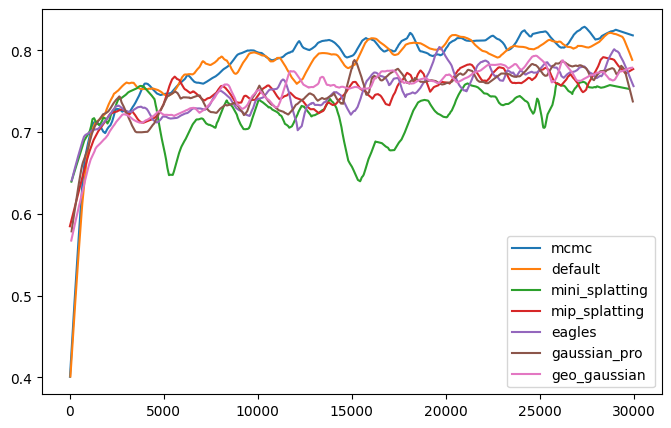

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm


def plot_single_facet_curve(
    df: pd.DataFrame,
    dataset_name: str,
    size: str,
    col: str,
    smooth_frac: float = 0.0,
    ax: plt.Axes | None = None,
) -> None:
    facet_df = df[((df["dataset_name"] == dataset_name) & (df["size"] == size))]

    if ax is None:
        plt.figure(figsize=(8, 5))
    for technique in facet_df["technique"].unique():
        subset = facet_df[(facet_df["technique"] == technique)]
        if smooth_frac > 0:
            lowess = sm.nonparametric.lowess(subset[col], subset["_step"], frac=smooth_frac)
            sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], label=technique, ax=ax)
        else:
            sns.lineplot(x=subset["_step"], y=subset[col], label=technique, ax=ax)

    if ax is None:
        plt.show()


plot_single_facet_curve(df_run, "truck", "low", "train/ssim", smooth_frac=0.05)

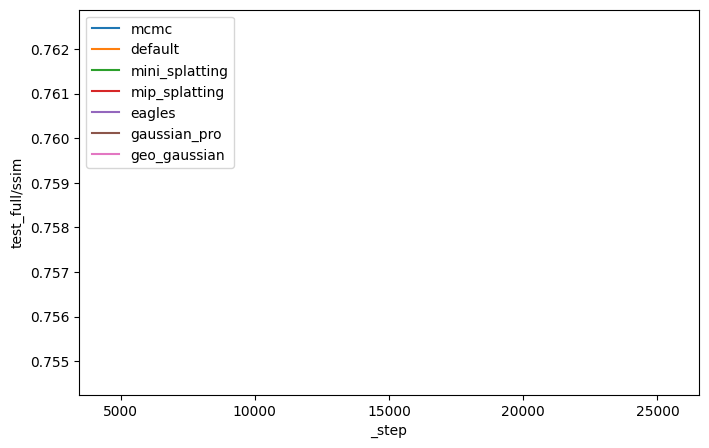

In [36]:
plot_single_facet_curve(df_run, "truck", "low", "test_full/ssim")

/home/paul/miniconda3/envs/firebase/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/miniconda3/envs/firebase/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/paul/miniconda3/envs/firebase/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/miniconda3/envs/firebase/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/paul/miniconda3/envs/firebase/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/paul/miniconda3/envs/firebase

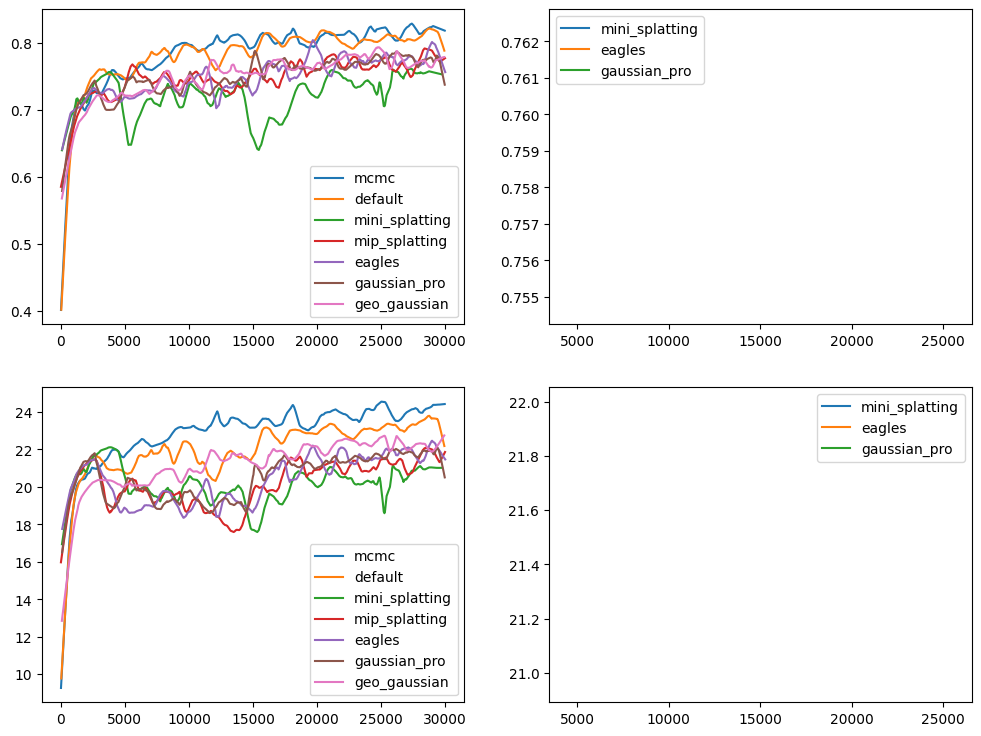

In [29]:
def contrast_train_and_test_progress(
    df: pd.DataFrame, dataset_name: str, size: str
) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    plot_single_facet_curve(df_run, dataset_name, size, "train/ssim", smooth_frac=0.05, ax=axs[0][0])
    plot_single_facet_curve(df_run, dataset_name, size, "test_full/ssim", ax=axs[0][1])
    plot_single_facet_curve(df_run, dataset_name, size, "train/psnr", smooth_frac=0.05, ax=axs[1][0])
    plot_single_facet_curve(df_run, dataset_name, size, "test_full/psnr", ax=axs[1][1])
    plt.show()

contrast_train_and_test_progress(df_run, "truck", "low")